<a href="https://colab.research.google.com/github/AnandKhandekar/Introduction-to-PyMC3/blob/master/Intro_to_PyMC3_1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3 :  Logistic Regression

* Produce an artificial dataset, represetning binary outcome as a function of a random variable drawn from a unifrom distribution.

* We will fit a Logistic Regresison model, to estimate the coefficient of X and th intercept.

* Posterior Predictive Checks on the test data, making out of the sample distribution.

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 7.6MB/s 
     |████████████████████████████████| 4.1MB 43.1MB/s 
     |████████████████████████████████| 327kB 47.4MB/s 
     |████████████████████████████████| 911kB 7.7MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [0]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import shared

%config InlineBackend.figure_formats = ['retina']
plt.rc('font', size=12)
plt.style.use('seaborn-darkgrid')

The outcome y variable will be binary. 

To swap out th X taiing data and use it as validation data w use 'shared'(X).. it is a Theano shared layer and w use it to wrap the X variable, so w will use X_ shared iinstead of X in the model.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:22<00:00, 67.25it/s]
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be 

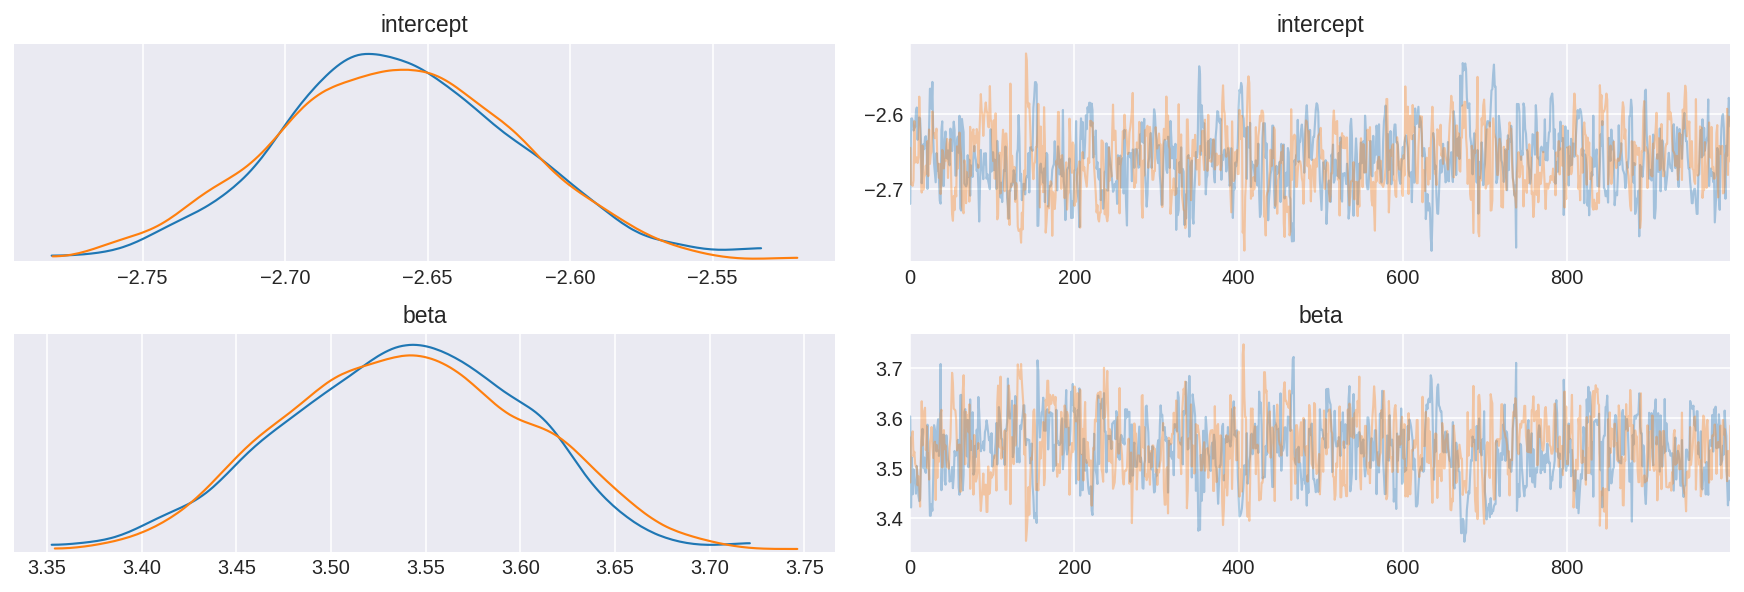

In [6]:
# generate artificail dataset
N = 10000
X = np.random.uniform(0,1,N)  #  data belongs to a uniform distribution 

# now we generate y, with the logic that if the value of 'x' is above a threshold of 0.7 then the data pointis assigned to 1 else it is assignd to 0.

def DGP(x):
    obs_y = []

    for n in range(len(x)):
        if x[n] > (0.7 + np.random.normal(0.0, 0.001, 1)[0]):
            obs_y.append(1.0)
        else :
            obs_y.append(0.0)
    
    return obs_y


X_shared = shared(X)
obs_y = DGP(X)

#2 Model the above data witha simple Regression model
with pm.Model() as exercise3 :

     intercept = pm.Normal('intercept', mu =0.0 , sd = 0.1)
     coeff = pm.Normal('beta', mu = 0.0, sd = 0.1)

     expected_value = pm.math.invlogit((coeff*X_shared) + intercept)  # sigmoid which outputs the continuous variable into either 0 or 1
     y = pm.Bernoulli('y', expected_value, observed = obs_y)
# the expected value here will try to estimate the p parameter of the Benoulli, i.e. the likelihood of getting 1 vs 0
     
     trace = pm.sample(1000)
     
     pm.traceplot(trace,['intercept','beta'])
     plt.show()

     

In [7]:
# 3. Poserior Predictive Checks

TEST_N = 1000   
testX = np.random.uniform(0, 1, TEST_N)  #  generate some test data, i.e new set of X value
testY = DGP(testX)  # use the SAME code to generate the Y vlaues

X_shared.set_value(testX)  # this tell the MODEL to use this DATA to make predictions rather than the previous trianing data

ppc = pm.sample_ppc(trace, model=exercise3, samples=500)  #  500 is the no of samples to be drawn per value of x
y_preds = ppc['y']

print("y_preds shape = ", y_preds.shape)

expected_y_pred = np.reshape(np.mean(y_preds, axis=0), [-1])  # we take the mean since we are intersed only in the best possible predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 280.71it/s]

y_preds shape =  (500, 1000)


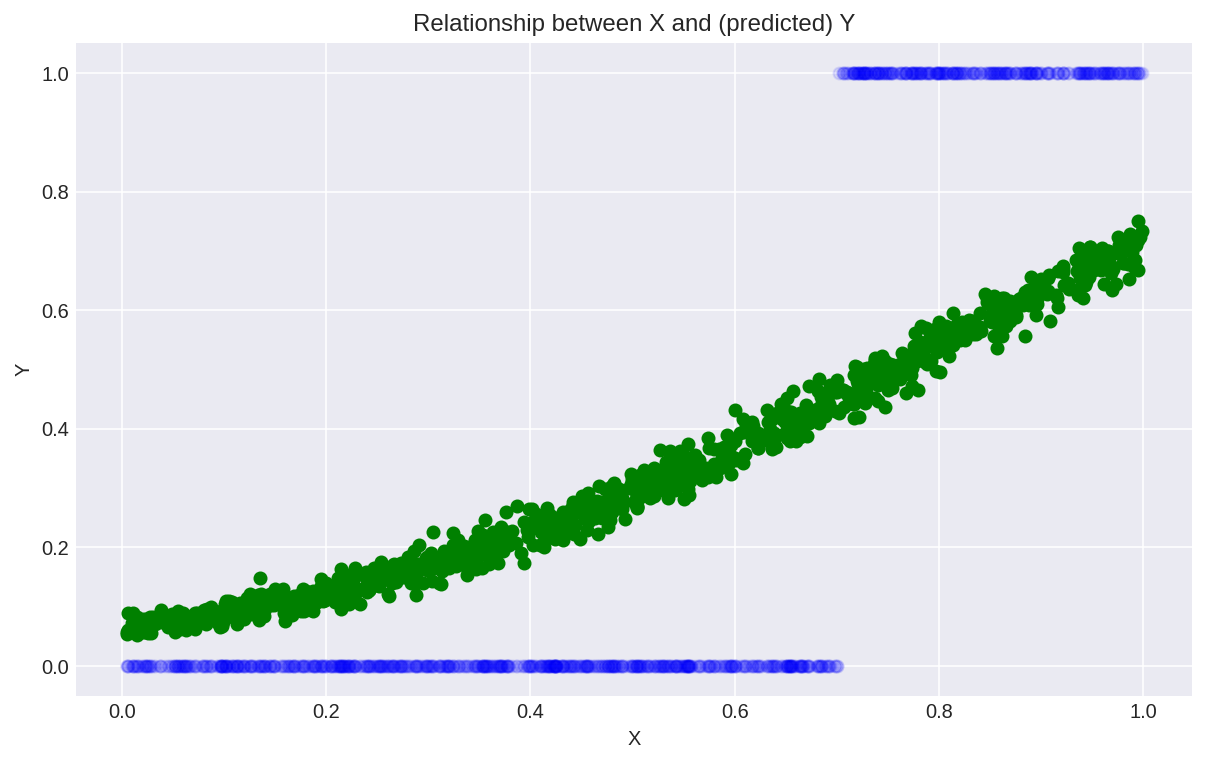

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(testX, expected_y_pred, c='g')
plt.scatter(testX, testY, c='b', alpha=0.1)
plt.title("Relationship between X and (predicted) Y")  # for each value of GREEN x what is the vlaue of BLUE y i.e. 0 or 1
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

Notice that the differentiation occurs at 0.7 threshold. Here the probability ( y axis) is 0.5